## 🎯#2. 실습 : qml 

QSVM 을 이용한 머신 러닝 모델을 적용하였습니다. QML 을 이용하여 적절한 QSVM 설정을 하였을 때 정확도가 올라가는 것을 확인하였습니다.
- 샘플링 갯수, PCA 차수 축소
- Featuremap 설정

### 🙏 참고한 자료
- [qiskit - Quantum Kernel Machine Learning](https://qiskit-community.github.io/qiskit-machine-learning/tutorials/03_quantum_kernel.html)


In [34]:
# !pip install qiskit-machine-learning --upgrade
# !pip show qiskit-machine-learning
# !pip install qiskit-aer

In [73]:
# ▶ 필요한 패키지 설치 (최초 1회만)
# pip install qiskit qiskit-machine-learning scikit-learn pandas numpy matplotlib

# from qiskit.utils import algorithm_globals
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.kernels import FidelityQuantumKernel#QuantumKernel
from qiskit.circuit.library import ZZFeatureMap, PauliFeatureMap
# from qiskit import BasicAer
from qiskit_aer import AerSimulator
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
from qiskit.primitives import Sampler, StatevectorSampler
from qiskit_machine_learning.state_fidelities import ComputeUncompute, BaseStateFidelity

# 1. 데이터 전처리
# fingerprint, label 데이터 불러오기(2048차원)
X_features = np.load("X_features_bc.npy")
y = np.load("y_labels_bc.npy")



In [74]:
print(X_features.shape)
print(y.shape)
print(X_small.shape)
print(y_small.shape)

(569, 30)
(569,)
(500, 2048)
(500, 1)


In [79]:

# 1.1. 샘플 수 제한 (양자 커널은 느림)
X_small = X_features[:500]
y_small = y[:500]#ravel()
unique, counts = np.unique(y_small, return_counts=True)
print(dict(zip(unique, counts)))
# 1.2. PCA로 차원 축소
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_small)

# 1.3. train/test 분할
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_small, test_size=0.2, stratify=y_small, random_state=42)
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))
unique, counts = np.unique(y_test, return_counts=True)
print(dict(zip(unique, counts)))
# 2. QSVM 준비
# 2.1. 양자 feature map 설정 (2-qubit ZZFeatureMap)
feature_map = ZZFeatureMap(feature_dimension=2, reps=3)

# 2.2. Quantum kernel 정의
sampler = StatevectorSampler()
fidelity = ComputeUncompute(sampler=sampler)#qiskit1.0 이상부터는 AerSimulator(method="statevector")으로 백엔드를 지정하는 대신에, StatevectorSampler를 샢플러로 쓰면 
quantum_kernel = FidelityQuantumKernel(feature_map=feature_map, fidelity = fidelity)

# 3. 학습
# 3.1. QSVM 학습용 커널 행렬 생성
kernel_train = quantum_kernel.evaluate(x_vec=X_train)#양자커널 함수값 계산. X_train의 데이터 내의 유사성을 계산. fidelity(x_i,x_j)

# 3.2. SVM 학습 (precomputed kernel 사용)
qsvm = SVC(kernel="precomputed", probability = True)
qsvm.fit(kernel_train, y_train)

# 4. 학습된 qvsm 으로 X_test 를 분류
kernel_test = quantum_kernel.evaluate(x_vec=X_test, y_vec=X_train)
y_pred = qsvm.predict(kernel_test)



{np.int64(0): np.int64(195), np.int64(1): np.int64(305)}
{np.int64(0): np.int64(156), np.int64(1): np.int64(244)}
{np.int64(0): np.int64(39), np.int64(1): np.int64(61)}


정확도55.00%


,precision,recall,f1-score,support
0,0.39,0.28,0.33,39.00
1,0.61,0.72,0.66,61.00
accuracy,0.55,0.55,0.55,0.55
macro avg,0.50,0.50,0.50,100.00
weighted avg,0.53,0.55,0.53,100.00


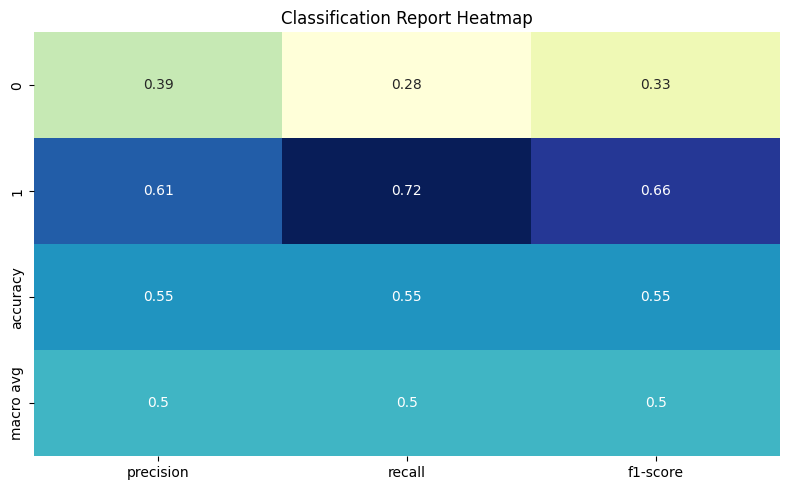

In [80]:
# 4. 예측 및 평가
from sklearn.metrics import accuracy_score
import seaborn as sns
import pandas as pd

accuracy = accuracy_score(y_test, y_pred)
print("정확도{:.2f}%".format(accuracy*100))

report_dict = classification_report(y_test, y_pred,output_dict=True)
df_report = pd.DataFrame(report_dict).transpose().round(2)
display(df_report)
# 'support'는 숫자 범위가 달라서 제외
df_plot = df_report.drop(columns=['support'], errors='ignore')
# 히트맵 그리기
plt.figure(figsize=(8, 5))
sns.heatmap(df_plot.iloc[:-1], annot=True, cmap="YlGnBu", cbar=False)
plt.title("Classification Report Heatmap")
plt.tight_layout()
plt.savefig("bc_QML_Pauli_cr.png", dpi=300)
plt.show()

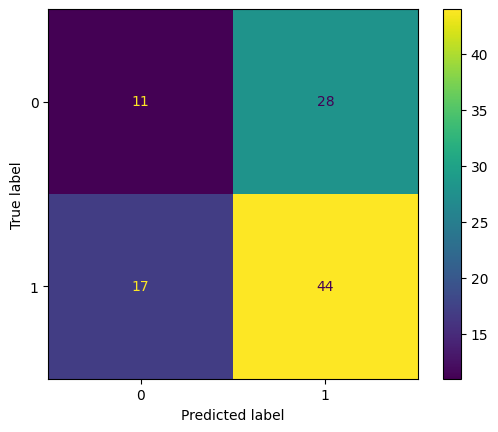

<Figure size 640x480 with 0 Axes>

In [81]:
#3.2. confusion matrix
from sklearn.metrics import accuracy_score, confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()
plt.savefig("image/bc_QML_Pauli_cm.png")


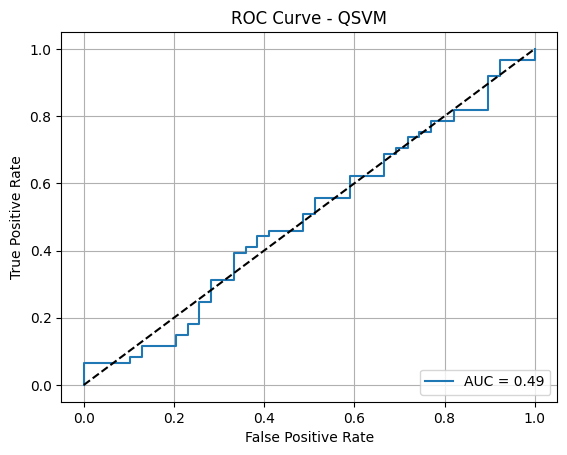

In [82]:
# 3.3. roc curve?
from sklearn.metrics import roc_curve, auc
# 확률 기반 예측값 추출
y_score = qsvm.predict_proba(kernel_test)[:, 1]

# ROC 커브 그리기
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - QSVM")
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig("image/bc_QML_Pauli_rc.png", dpi=300)
plt.show()

# print(X_features)
# print(y)

## ✍️ 배운 점
- 

## 📌 다음 목표
- 향후 QNN과 비교


## 💭궁금한 점 및 추가 정보

#### 1. BasicAer vs Aer 차이점
| 항목 | `BasicAer` | `Aer` |
| -- | -- | -- |
|  패키지 | `qiskit.providers.basicaer` | `qiskit-aer` (별도 설치 필요) |
| 시뮬레이터 종류 | 간단한 기본 시뮬레이터 | 고성능 고급 시뮬레이터 |
| 설치 여부 | Qiskit 기본 포함 | 별도 설치 필요 (`pip install qiskit-aer`) |
| 성능 | 느리고 기능 제한 | 빠르고 다양한 옵션 제공 (노이즈, GPU 등) |
| 지원 백엔드 | `statevector_simulator`, `qasm_simulator` | `aer_simulator_statevector`, `aer_simulator` 등 |
| 활용도 | 단순 실습용 | 실제 연구, 튜닝, 실전 실험용 |
| 유지보수 상태  | 거의 업데이트 없음 | 활발히 개발 중 |


#### 2. quantum_kernel.evaluate?
`kernel_train = quantum_kernel.evaluate(x_vec=X_train)`은 양자 커널 함수 값을 계산하는 함수.
$fidelity(\phi(X_train[i]),\phi(X_train[j]))$ 를 계산함. 
그래서 kernel_train 은 $(len(X_train) x len(X_train) 크기의 행렬

qml의 학습 `qsvm.fit(kernel_train, y_train)`에서는 X_train 자체가 아닌, 계산된 커널 행렬을 기반으로 학습함.

qml의 예측 `y_pred = qsvm.predict(kernel_test)`에서도, X_test 자체가 아닌, 사전에 계산된 커널 행렬을 이용함.
kernel_test 는 $(len(X_test) x len(X_train)$ 크기의 행렬
